In [15]:
"""
@author Ryan Williams
     
     Notebook 3 - Data Preprocessing Experiments

@date June-July, 2021
"""

'\n@author Ryan Williams\n     \n     Notebook 3 - Data Preprocessing Experiments\n\n@date June-July, 2021\n'

# Notebook 3 - Data Preprocessing Experiments

**Aim:** The aim of this notebook is to formally document experiements determining the most appropaite data preprocessing techniques for each  feature present witin the Physionet cardilogy challenge 2019 dataset. 

**Summary:** 
- Import necessary packages.
- Setup a colour palette for our later visualisations.
- Define the output directory for the figures we will create.
- Import the whole datasest into a dataframe object, from its stored pickle file, which was created by Notebook 1.
- Define and target the sparse features.
- Define helper functions.
- Main method - test each interpolation method's effectiveness for each feature, using the R squared score metric.
- Examine the results.

Import necessary packages.

In [16]:
# Imports
import pandas as pd  # For using pandas daraframe
import numpy as np   # For some maths operations
import matplotlib  # For Figure creation
import matplotlib.patches as mpatches  # For Figure creation
import matplotlib.pyplot as plt  # For Figure creat
import random  # For generating random numbers
from random import randrange  # For generating random numbers within a range
from sklearn.metrics import r2_score  # For comparing abilities of interpolation methods
import warnings  # To be able to ignore some warnings
warnings.filterwarnings('ignore')

Setup a colour palette for our later visualisations.

In [17]:
# Define a qualitative colour palette, from:
# palette generated at: https://colorbrewer2.org/#type=qualitative&scheme=Set3&n=7
colours = ['#80b1d3','#fb8072', '#8dd3c7', '#ffffb3', '#bebada', '#fdb462', '#b3de69']

 Define the output directory for the figures we will create.

In [18]:
# Define directory to save Figures as images too by defualt
figures_directory = './sepsis-detection/notebooks/Notebook 3 - Data Preprocessing Experiments/test/'

Lets import the dataset so it can be used in this notebook.

In [19]:
# Lets import the full parsed dataset.
full_dataset = pd.read_pickle('./sepsis-detection/data/interim/full_base_dataset.pkl')

# Create a copy to experiment upon.
dataset_preprocess = full_dataset.copy()

# Addressing Missing Values

Within Notebook 2 we saw that the dataset contains many missing values, here lets look at different ways to address these missing values. We will consider different methods and measure and compare their effectivness. We saw that there is a large disparity of sparsity of readings between features. For this reason we will attempt to address different features differently, addtionally some variables are in a time series, like O2 readings, while others are time non-time variant within the data such as age. 

Lets specify the data we need to ammend

In [20]:
# Lets select the features who contain missing datapoints
# based on our explorations within Notebook 2

# Define which features we believe to be sparse
sparse_features = ['patientID','EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets','HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Unit1', 'Unit2']

sparse_features_df = dataset_preprocess[sparse_features]

Lets create some helper functions we need to conduct our experiments

In [21]:
# Helper function which iterates through a dataset
# returning the patient with the least amount of
# missing values for each feature in the dataset
def find_best_patients (df):
    # Use a array to store the patientIDs we will record
    row_list = []
    # Iterate through each feature, missing the first one as its patientID
    for feature in df.columns.to_list()[1:]:
        # We group the dataset by patient, then create a column named
        # count which records how many null values each patient has
        # for the given feature, the dataframe is then sorted by count
        # and we append the first entry to our array
        row_list.append((df[feature].isnull().groupby(df['patientID']).sum().reset_index(name='count')).sort_values(by='count').head(1))
    return row_list

# Helper function which takes a df, adds a copy of a feature
# then removes a percentage of data from that copied feature
# returning an altered version of the dataset
def create_test_columns(df, missing_percent):
    # Reset the index we can index properly
    df = df.reset_index()
    # Parse the feature we want to use into a array
    missing = df[df.columns.to_list()[2]].to_list()
    # Iterate based on a percentage of missing specified
    for i in range(0, int(df.shape[0] * (missing_percent * 0.01))):
        # choose a random value to change to null, avoiding either end
        # as nullifying these will course errors with our interpolation methods
        missing[randrange(1,df.shape[0]-1)] = np.NaN
    # Pass back missing values back into the dataframe
    df['test_missing'] = missing
    # Return 
    return df

# Helper function which applies a range of imputation 
# methods to a dataframe, on the 'test_missing' feature
# for each method a new feature is added to the dataframe
# returned is the altered dataframe 
def apply_methods(df):
    # Averaging methods
    df['mean_fill'] = df['test_missing'].fillna(df['test_missing'].mean())
    df['median_fill'] = df['test_missing'].fillna(df['test_missing'].median())
    # Rolling Averaging methods
    df['mean_rolling'] = df['test_missing'].fillna(df['test_missing'].rolling(24,min_periods=1,).mean())
    df['median_rolling'] = df['test_missing'].fillna(df['test_missing'].rolling(24,min_periods=1,).median())
    # Interpolation Methods 
    df['interpolation_linear'] = df['test_missing'].interpolate(method='linear')
    df['interpolation_quadratic'] = df['test_missing'].interpolate(method='quadratic')
    df['interpolation_cubic'] = df['test_missing'].interpolate(method='cubic')
    df['interpolation_slinear'] = df['test_missing'].interpolate(method='slinear')
    df['interpolation_akima'] = df['test_missing'].interpolate(method='akima')
    df['interpolation_polynomial_5'] = df['test_missing'].interpolate(method='polynomial', order=5)
    df['interpolation_spline_3'] = df['test_missing'].interpolate(method='spline', order=3)
    df['interpolation_spline_4'] = df['test_missing'].interpolate(method='spline', order=4)
    df['interpolation_spline_5'] = df['test_missing'].interpolate(method='spline', order=5)
    # Return
    return df 

# Helper function which itterates through results
# within a given dataframe for a given feature and 
# applys the r squared equation,
# returning a dataframe

####### edit and clean 
def calcualte_r_sqaured_results(df, feature):

    results = [(method, r2_score(df[feature], df[method])) for method in list(df)[4:]]

    results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])

    return results_df.sort_values(by='R_squared', ascending=False)
    

# Main Method

In [22]:
# Find most appropiate patients to use their data for
# experiments - the least null for each feature
test_IDs = find_best_patients(sparse_features_df)

# Create a dictionary, keyed by each feature
# used to store a dataframe of each feature's
# most appropiate patient's data for that feature
test_features = {}

# Iterate through all of the different patientIDs
# for each ID find the patient data and place it into
# the dictionary
for item in range(0, len(test_IDs)):
    test_features[sparse_features_df.columns.to_list()[1:][item]] = (sparse_features_df.loc[sparse_features_df['patientID'] == test_IDs[item]['patientID'].to_list()[0]])[['patientID', sparse_features_df.columns.to_list()[1:][item]]]

# clean up our data, fill in missing data if needed 
###################################################
for key, value in test_features.items():
    # if the dataframe contains a null perform a forward fill padding
    # then a backwards padding incase of the first entry being missing 
    if ((test_features[key].isna().sum()[key])  > 0):
        test_features[key] = (test_features[key]).fillna(method="ffill").fillna(method="bfill")
###################################################

# Iterate through our dictionary adding the missing data test 
# columns to each dataframe
for key, value in test_features.items():
    test_features[key] = create_test_columns(value, 30)

# Iterate through our dictionary applying our interpolation methods
for key, value in test_features.items():
    test_features[key] = apply_methods(value)

# Create a new dictionairy for our results
# iterate through old dictionary plotting results across
results = {}
for key, value in test_features.items():
    results[key] = calcualte_r_sqaured_results(value, key)

Lets examine the results 

In [23]:
# Lets just examine the results top results in text
for key, value in results.items():
    print(key)
    print(results[key][:3], "\n")

EtCO2
           Method           R_squared
1     median_fill  0.5220483641536273
0       mean_fill  0.5113007744586693
3  median_rolling  0.2071123755334281 

BaseExcess
                    Method           R_squared
8      interpolation_akima  0.9908001984969165
6      interpolation_cubic  0.9898626092853112
5  interpolation_quadratic  0.9895982610274774 

HCO3
                    Method           R_squared
4     interpolation_linear                 1.0
7    interpolation_slinear                 1.0
10  interpolation_spline_3  0.9997243259221397 

FiO2
                       Method           R_squared
9  interpolation_polynomial_5  0.9992757549937725
6         interpolation_cubic  0.9984693474156278
5     interpolation_quadratic  0.9974365698176294 

pH
                    Method           R_squared
4     interpolation_linear   0.980325203252032
7    interpolation_slinear  0.9803252032520311
10  interpolation_spline_3  0.9758575422193301 

PaCO2
                  Method           R_s

Lets visualise some of these methods

In [24]:
# Lets make some nice graphs to view how these methods are working 

# Define a helper function to allow us to do this consistently

def top_methods_figure (feature):
    # Lets get the top three
    top_methods = (results[feature])['Method'].to_list()[:3]

    # Define figure's size, place in subplot, type, grid overlay.
    plt.figure(1, figsize=(16,9))
    plt.subplot(211)
    plt.subplots_adjust(hspace=0.3) # define better spacing between the subplots 

    # Plot each method as its own line
    plt.plot((test_features[feature])[top_methods[0]], label=top_methods[0], color=colours[1], marker='.', markersize=14)
    plt.plot((test_features[feature])[top_methods[1]], label=top_methods[1], color=colours[2], marker='.', markersize=14) 
    plt.plot((test_features[feature])[top_methods[2]], label=top_methods[2], color=colours[4], marker='.', markersize=14)  
    plt.plot((test_features[feature])[feature], label=feature, color=colours[0], linestyle='--', marker='.', markersize=15)
    plt.plot((test_features[feature])['test_missing'], label=feature, color=colours[0]) 
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)

    # Define the axis labels, title and properties of legend.
    legend = mpatches.Patch(color=colours[0], label=feature)
    method_1 = mpatches.Patch(color=colours[1], label=top_methods[0])
    method_3 = mpatches.Patch(color=colours[2], label=top_methods[1])
    method_2 = mpatches.Patch(color=colours[4], label=top_methods[2])

    top_interpolation = mpatches.Patch(color=colours[1], label=top_methods[0])
    plt.legend(handles=[legend, method_1, method_2, method_3], loc="upper right")
    plt.title('The top three performing interpolation methods applied to'+ str(feature)+'.')
    plt.xlabel('Time (hours)')
    plt.ylabel(feature)

    # Define figure's size, place in subplot, type, grid overlay.
    plt.subplot(212)
    plt.plot((test_features[feature])[top_methods[0]], label=top_methods[0], color=colours[1], marker='.', markersize=14) 
    plt.plot((test_features[feature])[feature], label=feature, color=colours[0], linestyle='--', marker='.', markersize=15)
    plt.plot((test_features[feature])['test_missing'], label=feature, color=colours[0]) 
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    # Define the axis labels, title and properties of legend.
    top_interpolation = mpatches.Patch(color=colours[1], label=top_methods[0])
    plt.legend(handles=[legend, top_interpolation], loc="upper right")
    plt.title('The top performing interpolation method applied to'+ str(feature)+'.')
    plt.xlabel('Time (hours)')
    plt.ylabel(feature)

    # Save our figure and then show 
    plt.savefig(figures_directory+'top_interpolation_'+str(feature)+'.jpg')
    plt.show()

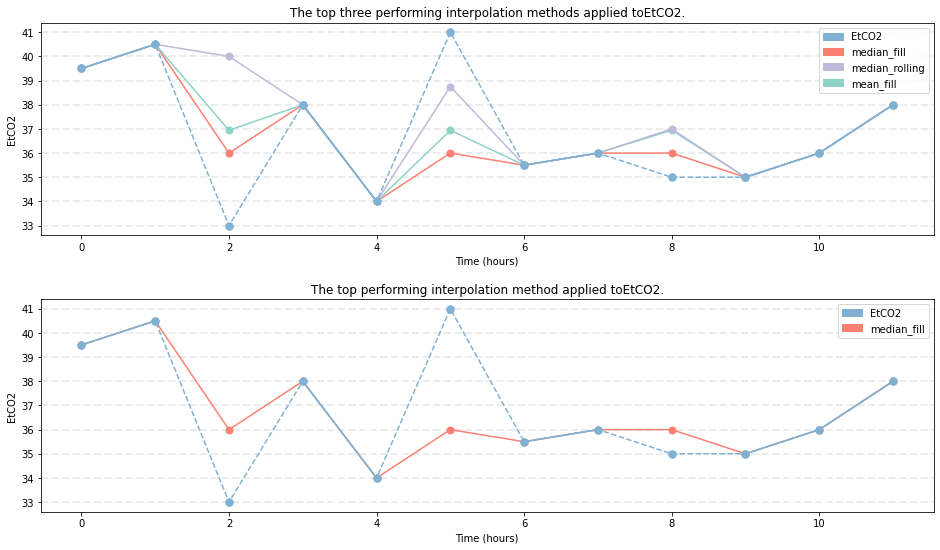

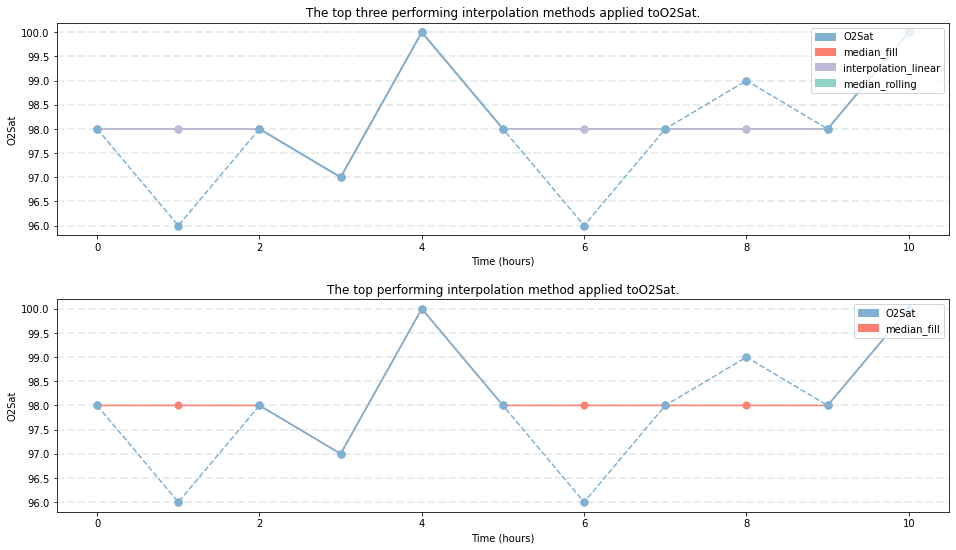

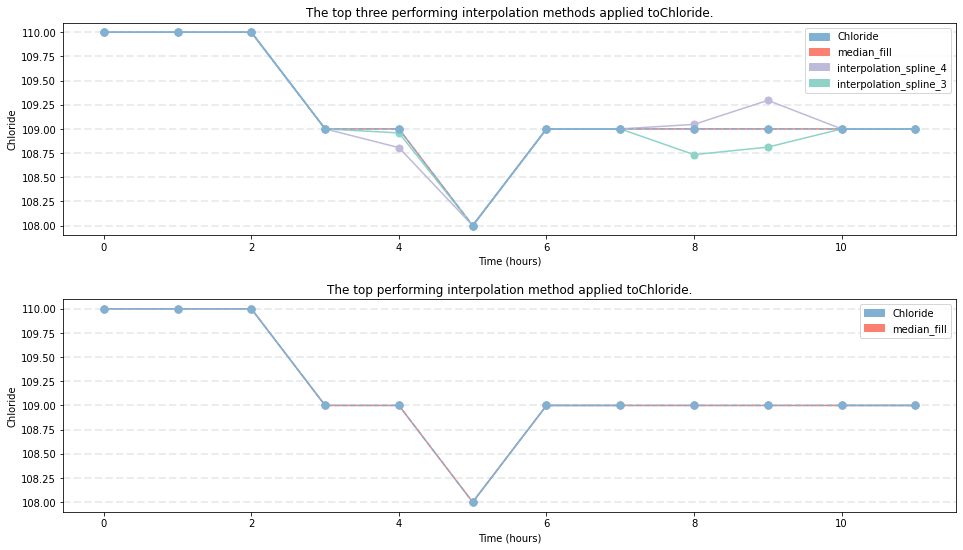

In [25]:
# Run our helper function 

top_methods_figure('EtCO2')

top_methods_figure('O2Sat')

top_methods_figure('Chloride')

Lets save the results so we can use them in later notebooks

In [28]:
# iterate through our dictionary and save the top performing method
# for each feature 
top = []
for key, value in results.items():
    top.append((results[key])['Method'].to_list()[0])

# Turn our results into a singular dataframe and save it as a pickle file
top_results = pd.DataFrame(data= ({'feature': results.keys(), 'top_method' : top}))
top_results.to_pickle('./sepsis-detection/notebooks/Notebook 3 - Data Preprocessing Experiments/test/top_methods.pkl')